In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50, EfficientNetB0, DenseNet121, Xception, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def load_image_paths_labels(folder_path, label):
    image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    labels = [label] * len(image_paths)
    return image_paths, labels

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset Paths
real_path = 'drive/MyDrive/real_and_fake_face/training_real'
fake_path = 'drive/MyDrive/real_and_fake_face/training_fake'

real_paths, real_labels = load_image_paths_labels(real_path, 1)
fake_paths, fake_labels = load_image_paths_labels(fake_path, 0)

image_paths = real_paths + fake_paths
labels = real_labels + fake_labels

df = pd.DataFrame({'Paths': image_paths, 'Real': labels})

def preprocess_image(path, target_size=(224, 224)):
    img = load_img(path, target_size=target_size)
    img_array = img_to_array(img)
    return preprocess_input(img_array)

df['image'] = df['Paths'].apply(preprocess_image)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Real'], random_state=123)
X_train, y_train = np.stack(train_df['image'].values), np.array(train_df['Real'].values)
X_test, y_test = np.stack(test_df['image'].values), np.array(test_df['Real'].values)

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Confusion Matrix": cm
    }
    return metrics

def plot_metrics(metrics):
    sns.heatmap(metrics["Confusion Matrix"], annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    for key, value in metrics.items():
        if key != "Confusion Matrix":
            print(f"{key}: {value:.4f}")

In [ ]:
# Function to build and train a model
def build_and_train_model(model_name, base_model_fn, preprocess_fn, epochs=20, batch_size=32):
    print(f"\nTraining {model_name}...\n")

    # Clear previous TensorFlow session
    tf.keras.backend.clear_session()

    # Apply model-specific preprocessing
    X_train_prep = preprocess_fn(X_train)
    X_test_prep = preprocess_fn(X_test)

    # Define model architecture
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
    ]

    # Train model
    start_time = time.time()
    history = model.fit(X_train_prep, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_prep, y_test), callbacks=callbacks)
    print(f"Training time for {model_name}: {time.time() - start_time:.2f} seconds")

    # Save model
    model.save(f"{model_name}.h5")
    print(f"{model_name} saved successfully.\n")

    # Evaluate model
    metrics = evaluate_model(model, X_test_prep, y_test)
    plot_metrics(metrics)



Training ResNet50...

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 378s 7s/step - accuracy: 0.5648 - loss: 0.9440 - val_accuracy: 0.4988 - val_loss: 0.8447 - learning_rate: 1.0000e-04
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 366s 7s/step - accuracy: 0.6180 - loss: 0.7307 - val_accuracy: 0.5770 - val_loss: 0.7106 - learning_rate: 1.0000e-04
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 366s 7s/step - accuracy: 0.6634 - loss: 0.6272 - val_accuracy: 0.6357 - val_loss: 0.6416 - learning_rate: 1.0000e-04
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 364s 7s/step - accuracy: 0.6692 - loss: 0.6287 - val_accuracy: 0.6455 - val_loss: 0.6472 - learning_rate: 1.0000e-04
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 364s 7s/step - accuracy: 0.7062 - loss: 0.5865 - val_accuracy: 0.6381 - val_loss: 0.6519 - learning_rate: 1.0000e-04
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 363s 7s/step - accuracy: 0.6955 - loss: 0.5931 - val_accuracy: 0.6381 - val_loss: 0.6549 - learning_rate: 2.0000e-05


Training time for ResNet50: 2202.27 seconds
ResNet50 saved successfully.

13/13 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step


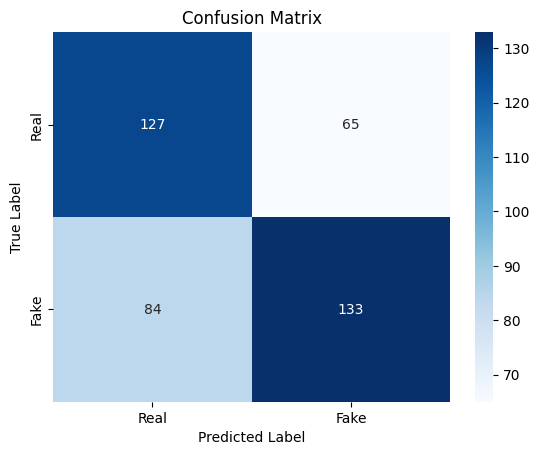

Accuracy: 0.6357
Precision: 0.6717
Recall: 0.6129
F1-Score: 0.6410


In [ ]:
build_and_train_model("ResNet50", ResNet50, tf.keras.applications.resnet50.preprocess_input)


Training EfficientNetB0...

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - accuracy: 0.5154 - loss: 0.9662 - val_accuracy: 0.5012 - val_loss: 0.7081 - learning_rate: 1.0000e-04
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.5581 - loss: 0.8639 - val_accuracy: 0.5501 - val_loss: 0.6961 - learning_rate: 1.0000e-04
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.6258 - loss: 0.7518 - val_accuracy: 0.5892 - val_loss: 0.6891 - learning_rate: 1.0000e-04
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.6273 - loss: 0.7210 - val_accuracy: 0.5990 - val_loss: 0.6803 - learning_rate: 1.0000e-04
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.6433 - loss: 0.6713 - val_accuracy: 0.5892 - val_loss: 0.6884 - learning_rate: 1.0000e-04
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.6439 - loss: 0.6938 - val_accuracy: 0.5819 - val_loss: 0.6936 - learning_rate: 1

Training time for EfficientNetB0: 1425.47 seconds
EfficientNetB0 saved successfully.

13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step


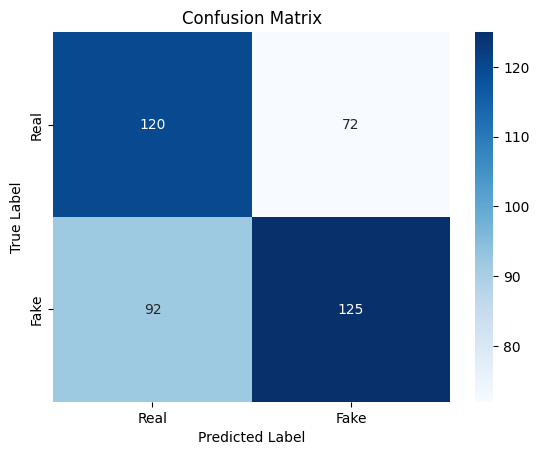

Accuracy: 0.5990
Precision: 0.6345
Recall: 0.5760
F1-Score: 0.6039


In [ ]:
build_and_train_model("EfficientNetB0", EfficientNetB0, tf.keras.applications.efficientnet.preprocess_input)

In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.17.0 requires tensorflow<2.18,>=2.17.0, but you have tensorflow 2.18.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
